In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.io import decode_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import os
import csv

# Aumentado de Datos

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 22/10/2025

> Asignatura: Programación para la Inteligencia Artificial

El Aprendizaje Profundo (como el Aprendizaje Computacional en general) está condicionado por los datos. Sin un buen conjunto de datos es dificil (o directamente imposible) conseguir buenos resultados.

Los datos con los que se realiza el ajuste van a condicionar inevitablemente lo que aprende el modelo. Por lo tanto, mejorar los datos suele conducir a mejorar los resultados. ¿Cómo los mejoramos? La manera más obvia es conseguir más datos, pero eso suele ser complicado. Si estamos trabajando con resonancias magnéticas para identificar epilepsias focales, aumentar el número de datos implica conseguir resonancias de nuevos pacientes que hayan sido debidamente etiquetadas por un médico. Conseguir un solo ejemplo requiere a una persona con dicha patología, una prueba específica con una máquina extremadamente costosa (y que requiere a un especialista para operarla) y la posterior participación de un médico especialista en el campo para generar la etiqueta correspondiente. En términos económicos el coste es muy alto así que una línea de trabajo es mejorar los datos sin que lleguen nuevos ejemplos. O no ejemplos genuinos del mundo real al menos.

Una opción es generar datos sintéticos utilizando Inteligencia Artificial. Es una línea de investigación abierta, pero todavía incipiente y poco fiable.

La aproximación más común es aplicar Aumentado de Datos (*Data Augmentation*). La idea es sencilla: tomar los datos que tenemos y generar nuevos ejemplos aplicandoles pequeñas alteraciones. Estas alteraciones deben tener sentido dentro del problema que trabajamos, por supuesto. Los datos en forma de imagen son especialmente susceptibles a este tipo de transformaciones.

Vamos a ver algunos ejemplos y cómo aplicarlas de manera sencilla con torchvision.

Para eso vamos a recuperar una función para mostrar imágenes y nuestra habitual imagen de Shin Chan.







In [17]:
from google.colab import drive
drive.mount('/content/drive')
workpath = '/content/drive/MyDrive/Work/Docencia UMA/2025-2026/Programacion para la IA/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

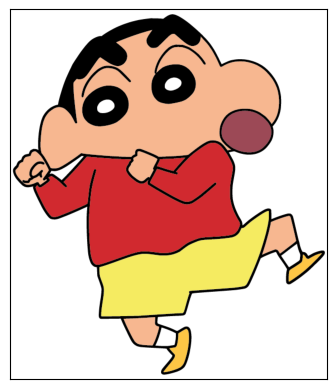

In [19]:
original_image = decode_image(os.path.join(workpath,'Shin Chan/shin_chan_2.png'), mode='RGBA')
show([original_image])

Esto es un Shin chan.

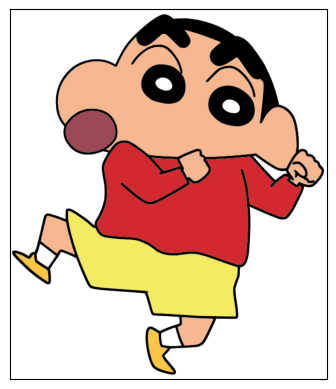

In [20]:
aug = transforms.RandomHorizontalFlip(p=1)
altered_image = aug(original_image)
show([altered_image])

Y esto también es un Shin Chan. **transforms.RandomHorizontalFlip** aplica un volteado de la imagen a lo largo del eje horizontal. Su entrada es la probabilidad con la que se desea que se aplique el volteado. Hemos elegido p=1 para asegurar que la imagen se voltea, pero habitualmente se elegiría p=0.5 para que la mitad de las veces la imagen sea volteada.

Lo mismo se aplica a **transforms.RandomVerticalFlip**, pero a lo largo del eje vertical:

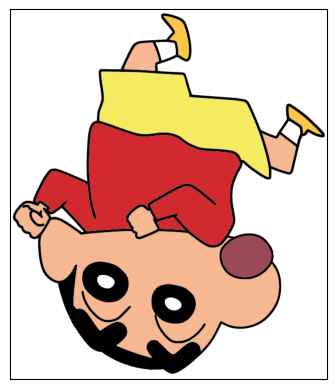

In [21]:
aug = transforms.RandomVerticalFlip(p=1)
altered_image = aug(original_image)
show([altered_image])

**transforms.RandomRotation** aplica una rotación aleatoria entre el rango de grados que se le indique. Si se le da un único número como hacemos a continuación, lo usará como referencia para el extremo inferior y superior del rango. En este caso la rotación irá entre -180 y 180 grados.

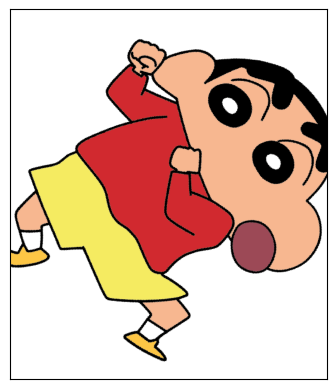

In [22]:
aug = transforms.RandomRotation(180)
altered_image = aug(original_image)
show([altered_image])

Las funciones de transformación habitualmente se pueden combinar, lo que aumenta aún más la variedad. En el ejemplo siguiente aplicamos tanto el volteo horizontal como el vertical con probabilidad 0.5, así que se pueden obtener 4 imágenes distintas.

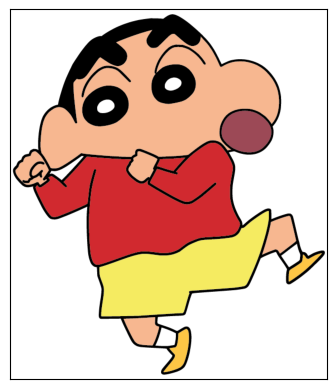

In [23]:
aug = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                          transforms.RandomVerticalFlip(p=0.5)])
altered_image = aug(original_image)
show([altered_image])

También es habitual hacer un recorte (*crop*) de la imagen.

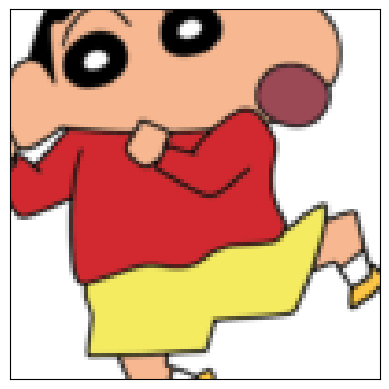

In [24]:
aug = transforms.Compose([transforms.Resize((140,120)),
                          transforms.RandomCrop((100,100))])
altered_image = aug(original_image)
show([altered_image])

Estas técncias son una manera sencilla de multiplicar el número de datos. A nuestros ojos la imagen puede parecer casi la misma, ¡pero para un sistema de Aprendizaje Profundo son imágenes distintas!

Además, los *datasets* de PyTorch generalmente ya contemplan que se les de una política de aumentado de datos para ser aplicada según se van pidiendo datos.

In [25]:
augmentation_policy = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.RandomCrop((23,23)),
                          transforms.RandomHorizontalFlip(p=0.5),
                          transforms.RandomVerticalFlip(p=0.5)])

dataset = datasets.MNIST(root=workpath, train=False, download=True, transform=augmentation_policy)

Vamos a probar a pedir varias veces el mismo dato:

label: 2


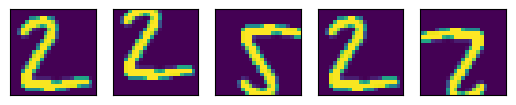

In [26]:
image_list = []
for _ in range(5):
  image, label = dataset[1]
  image_list.append(image)
show(image_list)

print(f"label: {label}")


Como podemos ver, distintas solicites del mismo dato llevan a imágenes distintas. En cada época de entrenamiento, el **DataLoader** debería pedir cada dato una vez. Si el la clase **Dataset** que usa va cambiando ligeramente el dato, en cada época el modelo ve el mismo dat de manera distinta, lo que incrementa su robustez a las variaciones.

El problema es que no todas las transformaciones tienen siempre sentido en todos los problemas. Aunque un Shin Chan al revés sigue siendo un Shin Chan, un 2 girado puede parecer un 5. ¡Hay que pensar qué clase de transformaciones tienen sentido en cada caso!

Uno puede implementar sus propias funciones de aumentado y hay diversas librerías para ello. Torchvision ofrece las más habituales para imágenes:

https://docs.pytorch.org/vision/main/transforms.html

Si rescatamos la clase ShiChanDataset de hace algunos cuadernos, ya contemplaba la aplicación de transformaciones tanto a los datos de entrada como a las salidas. No es habitual alterar los datos de salida, pero tampoco es inaudito. Todo depende del problema.

In [27]:
class ShinChanDataset(Dataset):
  def __init__(self, images_path, labels_path, transform=None, target_transform=None):
    self.images_path = images_path
    self.labels_path = labels_path
    self.transform = transform
    self.target_transform = target_transform

    # Vamos a cargar las etiquetas en el constructor. No ocupan mucho en memoria y
    # ahorramos tiempo de acceso a disco duro durante la ejecución.
    with open(self.labels_path, newline='') as csvfile:
      f = csv.reader(csvfile)
      self.labels = [int(l) for l in list(f)[0]]

  def __len__(self):
    # La longitud del Dataset coincide con el número de etiquetas.
    return len(self.labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.images_path, f"shin_chan_{idx}.png")
    image = decode_image(img_path)
    label = self.labels[idx]
    #Si hay transformaciones, las aplico.
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

In [28]:
augmentation_policy = transforms.Compose([
                          transforms.Resize((140,120)),
                          transforms.RandomRotation(180),
                          transforms.RandomCrop((100,100)),
                          transforms.RandomHorizontalFlip(p=0.5)])

shin_chan_dataset = ShinChanDataset(
    os.path.join(workpath, "Shin Chan",  "images"),
    os.path.join(workpath, "Shin Chan", "labels.csv"),
    transform=augmentation_policy
)

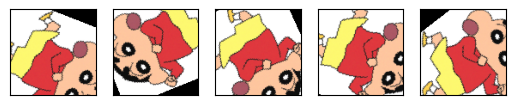

In [29]:
image_list = []
for _ in range(5):
  image, _ = shin_chan_dataset[0]
  image_list.append(image)
show(image_list)

El aumentado de datos se usa habitualmente durante el entrenamiento y la validación para aumentar la variabilidad de los datos. Aunque también se pueden aplicar al conjunto de test, generalmente se prefiere que ese conjunto sea siempre el mismo para poder hacer comparaciones fiables entre distintos experimentos, por lo que aplicar transformaciones no deterministas es contraproducente.

Sin embargo, el aumentado de datos tiene un uso muy interesante en el llamado *Test Time Augmentation* (TTA) que, pese a su nombre, no se refiere a simplemente aplicar aumentado de datos al conjunto de test.

Supongamos que tenemos un sistema entrenado para clasificar $C$ clases. Si tenemos que predecir la clase de una imagen, podemos predecir la clase de diversas versiones de la misma imagen generadas con aumentado de datos y combianr las predicciones para reducir la incertidumbre del sistema. Si un sistema entrenado con el MNIST predice para distintas variaciones de una imagen [1,2,1,1,7], Parece más probable que sea un 1.